# Load package

In [1]:
%cd ..

E:\Coding\Python\PlasmaChemistry


In [2]:
import os
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Layout
from IPython.display import display
import ipywidgets as widgets

In [4]:
from plasmistry.molecule import (H2_vib_group, CO_vib_group, CO2_vib_group)
from plasmistry.molecule import (H2_vib_energy_in_eV, H2_vib_energy_in_K,
                                 CO2_vib_energy_in_eV, CO2_vib_energy_in_K,
                                 CO_vib_energy_in_eV, CO_vib_energy_in_K)
from plasmistry.io import (LT_constructor, Arr_constructor, eval_constructor,
                           Cros_Reaction_block, Coef_Reaction_block)
from plasmistry.reactions import (CrosReactions, CoefReactions)
from plasmistry.electron import EEDF
from plasmistry.electron import get_maxwell_eedf

In [5]:
import yaml
yaml.add_constructor(u"!eval", eval_constructor)
yaml.add_constructor(u"!LT", LT_constructor)
yaml.add_constructor(u"!Arr", Arr_constructor)

# Set widgets

In [6]:
_species_list = ['E', 'H2(v0-14)', 'CO2(v0-21)', 'CO(v0-10)', 'O2', 'H2O', 'H', 'O', 'OH']
_init_yaml_file_path = './_yaml/test_0.yaml'
_vari_dict = dict(H2_vib_energy_in_eV=H2_vib_energy_in_eV,
                 CO2_vib_energy_in_eV=CO2_vib_energy_in_eV,
                 CO2_vib_energy_in_K=CO2_vib_energy_in_K)

# Load reactions


Reactions contains `electron reactions` and `relaxation reactions`



## functions
- `get_species_from_widgets`
- `load_reactions_from_widgets`
- `get_rctn_df_from_widgets`

In [7]:
rctn_considered = None
rctn_df = {'electron reactions': None, 'relaxation reactions': None}


def get_species_from_widgets(_event):
    print('set_species...', end=' ')
    species = []
    for _ in _widgets['species'].value:
        if _ == 'H2(v0-14)':
            species.append('H2')
            species.extend([f'H2(v{v})' for v in range(1, 15)])
        elif _ == 'CO2(v0-21)':
            species.append('CO2')
            species.extend([f'CO2(v{v})' for v in range(1, 22)])
        elif _ == 'CO(v0-10)':
            species.append('CO')
            species.extend([f'CO(v{v})' for v in range(11)])
        else:
            species.append(_)
    rctn_df['species'] = pd.Series(species)
    print('set done!')


# --------------------------------------------------------------------------- #


def load_reactions_from_widgets():
    with open(_widgets['path'].value, 'r') as f:
        rctn_block = yaml.load(f)
    return rctn_block[-1]['The reactions considered']


rctn_df = dict()


def get_rctn_df_from_widgets(_):
    print('loading...', end=' ')
    rctn_df['electron reactions'] = pd.DataFrame(
        columns=['formula', 'type', 'threshold_eV', 'cross_section'])
    rctn_df['relaxation reactions'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    # ----------------------------------------------------------------------- #
    for _ in _widgets['ele'].value:
        _df = rctn_all['electron reactions'][_]
        _cros_block = Cros_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict)
        rctn_df['electron reactions'] = rctn_df['electron reactions'].append(
            _cros_block.generate_crostn_dataframe())
    for _ in _widgets['rel'].value:
        _df = rctn_all['relaxation reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict)
        rctn_df['relaxation reactions'] = rctn_df[
            'relaxation reactions'].append(
                _coef_block.generate_crostn_dataframe())
    print('Get rctn_df done!')

# Set GUI

In [8]:
_widgets = dict()
_widgets['path'] = widgets.Text(value=_init_yaml_file_path)
display(widgets.HBox([widgets.HTML('<b>Yaml File Path</b>'),
                      _widgets['path']]))
rctn_all = load_reactions_from_widgets()
# --------------------------------------------------------------------------- #
# set select multiple
for _, _option in [('ele', rctn_all['electron reactions'].keys()),
                   ('rel', rctn_all['relaxation reactions'].keys()),
                   ('species', _species_list)]:
    _widgets[_] = widgets.SelectMultiple(options=_option,
                                         layout=Layout(height='300px'))
# --------------------------------------------------------------------------- #
# set floattext
for _, _value in [('electron_density', 1.0), ('Te', 1.0), ('CO2_density', 1.0),
                  ('CO2_Tvib', 1000), ('H2_density', 1.0), ('H2_Tvib', 1000),
                  ('CO_density', 1.0), ('CO_Tvib', 1000)]:
    _widgets[_] = widgets.FloatText(value=_value, layout=Layout(width='100px'))
# --------------------------------------------------------------------------- #
# set buttons
_button = dict()
_button['load reactions'] = widgets.Button(description='Load Reactions')
_button['set init-conditions'] = widgets.Button(
    description='Set init-conditions')

# --------------------------------------------------------------------------- #
display(
    widgets.HBox([
        widgets.VBox(
            [widgets.HTML('<b>ELECTRON REACTIONS:</b>'), _widgets['ele']]),
        widgets.VBox(
            [widgets.HTML('<b>RELAXATION REACTIONS:</b>'), _widgets['rel']]),
        widgets.VBox([widgets.HTML('<b>SPECIES</b>'), _widgets['species']])
    ]))
display(
    widgets.GridBox([
        widgets.HTML('<b>electron density</b>'), _widgets['electron_density'],
        widgets.HTML('<b>Te_eV</b>'), _widgets['Te'],
        widgets.HTML('<b>CO2_density</b>'), _widgets['CO2_density'],
        widgets.HTML('<b>CO2_Tvib</b>'), _widgets['CO2_Tvib'],
        widgets.HTML('<b>H2_density</b>'), _widgets['H2_density'],
        widgets.HTML('<b>H2_Tvib'), _widgets['H2_Tvib']
    ],
                    layout=widgets.Layout(
                        grid_template_columns="repeat(4, 20%)")))
display(
    widgets.HBox([_button['load reactions'], _button['set init-conditions']]))
_button['load reactions'].on_click(get_rctn_df_from_widgets)
_button['set init-conditions'].on_click(get_species_from_widgets)

GridBox(children=(HTML(value='<b>electron density</b>'), FloatText(value=1.0, layout=Layout(width='100px')), H…

loading... Get rctn_df done!


C:\Users\PhyMan\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


set_species... set done!


In [10]:
rctn_df['electron reactions']

,formula,type,threshold_eV,cross_section
0,E + H2 => E + H2(v1),EXCITATION,0.515594,"[[0.0001, 0.00010016132706854269, 0.0001003229..."
1,E + H2 => E + H2(v2),EXCITATION,1.001103,"[[0.4856084787426168, 0.48560864006968535, 0.4..."
2,E + H2 => E + H2(v3),EXCITATION,1.456525,"[[0.9410309521450216, 0.9410311134720902, 0.94..."
3,E + H2 => E + H2(v4),EXCITATION,1.881862,"[[1.3663674202072145, 1.366367581534283, 1.366..."
4,E + H2 => E + H2(v5),EXCITATION,2.277112,"[[1.7616178829291946, 1.7616180442562632, 1.76..."
5,E + H2 => E + H2(v6),EXCITATION,2.642277,"[[2.1267823403109634, 2.1267825016380315, 2.12..."
6,E + H2 => E + H2(v7),EXCITATION,2.977355,"[[2.461860792352519, 2.461860953679587, 2.4618..."
7,E + H2 => E + H2(v8),EXCITATION,3.282348,"[[2.7668532390538636, 2.7668534003809317, 2.76..."
8,E + H2 => E + H2(v9),EXCITATION,3.557254,"[[3.0417596804149953, 3.0417598417420635, 3.04..."
9,E + H2 => E + H2(v10),EXCITATION,3.802075,"[[3.286580116435915, 3.286580277762983, 3.2865..."


In [ ]:
rctn_df['relaxation reactions']

In [11]:
# density_df = pd.Series(0, index=species)
# H2 = H2_vib_group(total_density=_widgets['H2_density'].value,
        #           Tvib_K=_widgets['H2_Tvib'].value)
# CO2 = CO2_vib_group(total_density=_widgets['CO2_density'].value,
  #                   Tvib_K=_widgets['CO2_Tvib'].value)
# CO = CO_vib_group(total_density=_widgets['CO_density'].value,
   #                Tvib_K=_widgets['CO_Tvib'].value)

# Instance rctn_df

In [12]:
rctn_instances = {'electron reactions': None, 'relaxation reactions': None}


def from_rctn_df_to_cros_instance(_df):
    split_df = _df['formula'].str.split('\s*=>\s*', expand=True)
    reactant = split_df[0]
    product = split_df[1]
    return reactant, product


def from_rctn_df_to_coef_instance(_df):
    reactant = _df['reactant']
    product = _df['product']
    kstr = _df['kstr']
    return reactant, product, kstr


reactant, product = from_rctn_df_to_cros_instance(
    rctn_df['electron reactions'])
rctn_instances['electron reactions'] = CrosReactions(
    species=rctn_df['species'], reactant=reactant, product=product, k_str=None)
reactant, product, kstr = from_rctn_df_to_coef_instance(
    rctn_df['relaxation reactions'])
rctn_instances['relaxation reactions'] = CoefReactions(
    species=rctn_df['species'], reactant=reactant, product=product, k_str=kstr)
rctn_instances['relaxation reactions'].compile_k_str()
# rctn_instances['relaxation reactions'].set_rate_const(Tgas_K=1000, EN_Td=1, Te_eV=0)

In [13]:
eedf = EEDF(max_energy_eV=30, grid_number=300)
electron_energy_grid = eedf.energy_point
eedf.set_density_per_J(get_maxwell_eedf(eedf.energy_point, Te_eV=1.0))

In [21]:
rctn_instances['electron reactions'].set_rate_const_matrix(
    crostn_dataframe=rctn_df['electron reactions'],
    electron_energy_grid=electron_energy_grid)

In [87]:
y0 = rctn_instances['electron reactions'].get_initial_density(density_dict={
    'CO2': 2.4e24*0.5,
    'H2': 2.4e24*0.5,
    'E': 1e20
}, min_density=1e1)

normalized_eedf = get_maxwell_eedf(eedf.energy_point, Te_eV=1.0)

def dndt_cros(t, y):
    _instance = rctn_instances['electron reactions']
    _instance.set_rate_const(eedf_normalized=normalized_eedf)
    _instance.set_rate(density=y)
    return _instance.get_dn()


def dndt_coef(t, y):
    _instance = rctn_instances['relaxation reactions']
    _instance.set_rate_const(Tgas_K=4000, EN_Td=1.0, Te_eV=1.0)
    _instance.set_rate(density=y)
    return _instance.get_dn()

def dndt_all(t, y):
    print(t)
    # if t > t_res:
   #      _y = np.hstack([0,y[1:]])
   #  else:
   #      _y = y
    return dndt_cros(t, y) + dndt_coef(t, y)

In [88]:
time_span = (0, 1e-3)
sol = solve_ivp(dndt_all, time_span, y0, method='BDF', rtol=1e-1)

0.0
1.7478423061004424e-47
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.7478423061004425e-45
1.7478423061004425e-45
3.495684612200885e-45
3.495684612200885e-45
2.097410767320531e-44
2.097410767320531e-44
3.8452530734209733e-44
3.8452530734209733e-44
2.1323676134425396e-43
2.1323676134425396e-43
3.880209919542982e-43
3.880209919542982e-43
2.1358632980547403e-42
2.1358632980547403e-42
3.883705604155182e-42
3.883705604155182e-42
2.1362128665159602e-41
2.1362128665159602e-41
3.884055172616402e-41
3.884055172616402e-41
2.136247823362082e-40
2.136247823362082e-40
3.884090129462524e-40
3.884090129462524e-40
2.1362513190466944e-39
2.1362513190466944e-39
3.8840936251471365e-39
3.8840936251471365e-39
2.1362516686151558e-38
2.1362516686151558e-38
3.8840939747155977e-38
3.8840939747155977e-38
2.1362517035720017e

7.90649991034915e-07
1.2151974772701763e-06
1.2151974772701763e-06
1.2151974772701763e-06
1.6397449635054376e-06
1.6397449635054376e-06
1.6397449635054376e-06
2.064292449740699e-06
2.064292449740699e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089902473714956e-06
5.089

C:\Users\PhyMan\Anaconda3\lib\site-packages\scipy\integrate\_ivp\bdf.py:212: LinAlgWarning: Diagonal number 55 is exactly zero. Singular matrix.
  return lu_factor(A, overwrite_a=True)



1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
1.0857471581915897e-05
7.90277429

3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
3.1225838928902936e-05
2.671732866120677e-05
2.6717328661

5.941269619730632e-05
5.941269619730632e-05
5.941269619730632e-05
5.941269619730632e-05
5.941269619730632e-05
5.941269619730632e-05
5.941269619730632e-05
5.941269619730632e-05
5.941269619730632e-05
5.941269619730632e-05
5.941269619730632e-05
5.941269619730632e-05
6.478725925675096e-05
6.478725925675096e-05
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.00011853288985119732
0.

0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.00031345300258457534
0.000313453

0.00032284465280917935
0.00032128364037636186
0.00032128364037636186
0.00032050313415995314
0.00032050313415995314
0.0003201128810517488
0.0003201128810517488
0.0003205031341599532
0.0003205031341599532
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.00032440566524199706
0.0003244056652

0.0004529702928742343
0.00045180724797988346
0.00045180724797988346
0.000451225725532708
0.000451225725532708
0.0004518072479798834
0.0004518072479798834
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.00045762247245163747
0.0004576224724516

0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.0004762465238726477
0.00047624

0.000478733482113206
0.000478733482113206
0.000478733482113206
0.000478733482113206
0.000478733482113206
0.000478733482113206
0.000478733482113206
0.000478733482113206
0.000478733482113206
0.000478733482113206
0.000478733482113206
0.000478733482113206
0.000478733482113206
0.00047704102904226836
0.00047704102904226836
0.00047619480250679955
0.00047619480250679955
0.0004757716892390652
0.0004757716892390652
0.0004761948025067996
0.0004761948025067996
0.0004804259351841439
0.0004804259351841439
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.00048465706786148823
0.000484657067861488

0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0005018517258157692
0.0004998341645339242
0.00049983

0.0005244105705841797
0.0005244105705841797
0.0005220054501138412
0.0005220054501138412
0.000520802889878672
0.000520802889878672
0.0005220054501138412
0.0005220054501138412
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310524655342
0.0005340310

0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0006091591388370787
0.0005804878685817614
0.0005804878685817614
0.0005661522334541027
0.0005661522334541027
0.0005589844158902734
0.0005589844158902734
0.0005554005071083587
0.0005554005071083587
0.0005536085527174014
0.0005536085527174014
0.0005527125755219228
0.0005527125755219228
0.0005522645869241834
0.0005522645869241834
0.0005527125755219228
0.00055271

0.000560013717817354
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.0005685584222114885
0.000568558

0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0005951931182444894
0.0006015594191210291
0.0006015594191210291
0.0006652224278864258
0.0006652224278864258
0.0006652224278864258
0.0006652224278864258
0.0006652224278864258
0.0006652224278864258
0.0006652224278864258
0.0006652224278864258
0.0006652224278864258
0.0006652224278864258
0.00066522

0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006109608259635502
0.0006094429815544328
0.0006094429815544328
0.000608684059349874
0.000608684059349874
0.0006094429815544328
0.0006094429815544328
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322036000199
0.0006170322

0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.0006399084923301471
0.00063990

0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006482586880260672
0.0006439447147504171
0.0006439447147504171
0.000641787728112592
0.000641787728112592
0.0006407092347936794
0.0006407092347936794
0.0006401699881342232
0.0006401699881342232
0.0006407092347936794
0.0006407092347936794
0.0006461017

0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006619269320278745
0.0006593556035812181
0.0006593556035812181
0.0006580699393578899
0.00065806

0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.0006693764318170198
0.00066937

0.0006796565854355974
0.0006796565854355974
0.0006796565854355974
0.0006796565854355974
0.0006796565854355974
0.0006796565854355974
0.0006796565854355974
0.0006796565854355974
0.0006796565854355974
0.0006796565854355974
0.0006796565854355974
0.0006796565854355974
0.0006796565854355974
0.0006767333234371576
0.0006767333234371576
0.0006752716924379377
0.0006752716924379377
0.0006745408769383277
0.0006745408769383277
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.0006752716924379376
0.00067527

0.0006874293506760768
0.0006874293506760768
0.0006930050304521532
0.0006930050304521532
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.0007487618282129174
0.00074876

0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007322975101241378
0.0007281433049687079
0.0007281433049687079
0.000726066202390993
0.000726066202390993
0.0007250276511021356
0.0007250276511021356
0.0007260662023909931
0.0007260662023909931
0.0007364517152795684
0.0007364517152795684
0.0007364517152795684
0.0007364517152795684
0.0007364517152795684
0.0007364517

0.0007564944113259463
0.0007564944113259463
0.0007540183120998115
0.0007540183120998115
0.000752780262486744
0.000752780262486744
0.0007521612376802103
0.0007521612376802103
0.0007518517252769434
0.0007518517252769434
0.0007521612376802103
0.0007521612376802103
0.0007552563617128786
0.0007552563617128786
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514857455469
0.0007583514

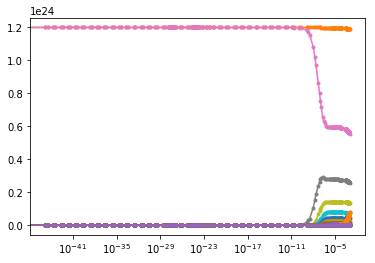

In [89]:
plt.semilogx(sol.t, sol.y.transpose(), marker='.')

In [90]:
rctn_instances['relaxation reactions'].set_rate(density=sol.y[:,-1])
rctn_instances['relaxation reactions'].view_rate_const_and_rate()

,formula,rate_const,rate
0,CO2(v1) + CO2 => CO2 + CO2,1.066868e-17,1.522440e+30
1,CO2(v2) + CO2 => CO2(v1) + CO2,1.207423e-17,8.844812e+29
2,CO2(v3) + CO2 => CO2(v2) + CO2,1.366496e-17,5.509998e+29
3,CO2(v4) + CO2 => CO2(v3) + CO2,1.546526e-17,3.580428e+29
4,CO2(v5) + CO2 => CO2(v4) + CO2,1.750274e-17,2.376728e+29
5,CO2(v6) + CO2 => CO2(v5) + CO2,1.980865e-17,1.591121e+29
6,CO2(v7) + CO2 => CO2(v6) + CO2,2.241835e-17,1.066381e+29
7,CO2(v8) + CO2 => CO2(v7) + CO2,2.537186e-17,7.132873e+28
8,CO2(v9) + CO2 => CO2(v8) + CO2,2.871448e-17,4.753163e+28
9,CO2(v10) + CO2 => CO2(v9) + CO2,3.249748e-17,3.152909e+28


In [91]:
rctn_instances['electron reactions'].set_rate(density=sol.y[:,-1])
rctn_instances['electron reactions'].view_rate_const_and_rate()

,formula,rate_const,rate
0,E + H2 => E + H2(v1),1.744353e-15,2.072810e+29
1,E + H2 => E + H2(v2),7.328467e-17,8.708397e+27
2,E + H2 => E + H2(v3),6.925277e-18,8.229289e+26
3,E + H2 => E + H2(v4),1.211536e-18,1.439665e+26
4,E + H2 => E + H2(v5),3.059127e-19,3.635153e+25
5,E + H2 => E + H2(v6),9.635746e-20,1.145013e+25
6,E + H2 => E + H2(v7),3.480271e-20,4.135596e+24
7,E + H2 => E + H2(v8),1.370119e-20,1.628108e+24
8,E + H2 => E + H2(v9),5.695053e-21,6.767417e+23
9,E + H2 => E + H2(v10),2.448205e-21,2.909195e+23


In [92]:
rctn_instances['electron reactions'].view_density(sol.y[:,-1]).sort_values(by='density', ascending=False)

,density,ratio
H2,1.188297e+24,48.1%
CO2,5.523963e+23,22.4%
CO2(v1),2.583324e+23,10.5%
CO2(v2),1.326106e+23,5.4%
CO,8.168746e+22,3.3%
H2O,8.168745e+22,3.3%
CO2(v3),7.299486e+22,3.0%
CO2(v4),4.191090e+22,1.7%
CO2(v5),2.458231e+22,1.0%
CO2(v6),1.454111e+22,0.6%


In [93]:
rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['O', 'density']

0.00018263878829641284

In [94]:
rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['H', 'density']

7.794141999555265e+18

In [95]:
rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['OH', 'density']

0.06381447268379864

In [ ]:
# plot CO2 vdf
_df = rctn_instances['electron reactions'].view_density(sol.y[:,-1])
x = ['CO2'] + [f'CO2(v{v})' for v in range(1, 22)]
y = [_df.loc[_,'density'] for _ in x]
plt.semilogy(range(22),y, marker='.')

In [29]:
Tv_CO2 = -3380/np.log(_df.loc['CO2(v1)','density']/_df.loc['CO2','density'])
Tv_H2 = -5983/np.log(_df.loc['H2(v1)','density']/_df.loc['H2','density'])
print(f"Tvib(CO2): {Tv_CO2:.0f} K")
print(f"Tvib(H2): {Tv_H2:.0f} K")

Tvib(CO2): 4055 K
Tvib(H2): 147 K


In [ ]:
y0